<a href="https://colab.research.google.com/github/huetech/TFG/blob/main/TFG_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Package Installation

All the necessary packages required for the data extraction, manipulation and training with and without Data Augmentation. This section is prepared to be executed within a Google Colab notebook.

In [9]:
%pip install tensorflow keras matplotlib gdown

# Library Imports

  All the necessary libraries needeed and the verification of the executing enviroment

In [10]:
import os
import shutil
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import numpy as np
import tensorflow as tf

In [11]:
# Making sure the GPU is active
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('No GPU found. Make sure is correctly configured.')
print('A GPU was found in: {}'.format(device_name))

A GPU was found in: /device:GPU:0


# Dataset Download

In order to make this notebook more portable, This code snippet allows you to download and decompress the dataset containing the images directly from the source.

## Dataset: COVID-19 Radiography Database

The first dataset being used is the **COVID-19 Radiography Database**. As specified in the description: "a database of chest X-ray images for COVID-19 positive cases along with Normal and Viral Pneumonia images. This COVID-19, normal, and other lung infection dataset is released in stages." for more information check the [official site](https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database).

In [16]:
# Importing the file  kaggle.json to download the datase
from google.colab import files
files.upload()  # Selecting kaggle.json

# Configure Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Downloading & decompressing COVID-19 dataset
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database
!unzip -q covid19-radiography-database.zip -d /content

# Reorganizing two folders
import os, shutil
os.makedirs('/content/covid_binary_dataset/COVID', exist_ok=True)
os.makedirs('/content/covid_binary_dataset/Normal', exist_ok=True)

for cls in ['COVID', 'Normal']:
    src_dir = f'/content/COVID-19_Radiography_Dataset/{cls}/images'
    dst_dir = f'/content/covid_binary_dataset/{cls}'
    for file in os.listdir(src_dir):
        if file.endswith('.png'):
            shutil.copy(os.path.join(src_dir, file), os.path.join(dst_dir, file))

Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors
covid19-radiography-database.zip: Skipping, found more recently modified local copy (use --force to force download)


## Dataset: CUB-200-2011

The dataset being used is the **CUB-200-2011**. As specified in the description: "CUB-200-2011 is an extended version of CUB-200, a challenging dataset of 200 bird species. The extended version roughly doubles the number of images per category and adds new part localization annotations" for more information check the [official site](https://authors.library.caltech.edu/records/cvm3y-5hh21).

In [5]:
from google.colab import drive

# Mount google drive
drive.mount('/content/drive')

# Download the folder containing the dataset
folder_id = '1kFzIqZL_pEBVR7Ca_8IKibfWoeZc3GT1'
!gdown --folder https://drive.google.com/drive/folders/{folder_id}

# Verify the download
dataset_dir = '/content/cub-200-2011'
print(os.listdir(dataset_dir))

# Extract the images for the .tgz
!tar -xvzf /content/cub-200-2011/CUB_200_2011.tgz -C /content/cub-200-2011/

Se han truncado las últimas 5000 líneas del flujo de salida.
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0050_111087.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0079_113288.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0004_111989.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0068_113247.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0127_111935.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0094_112773.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0028_113217.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0126_110959.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0007_111029.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0096_111519.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0120_113001.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0010_112678.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0025_111669.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_008

# General Configuration

General configuration for the neural network images input size and the batch size will be used

In [2]:
image_size = (224, 224)
batch_size = 32
input_shape = (224, 224, 3)

### Model Generator Functions

In [3]:
def prepare_generators(data_dir, augment=False, class_mode='binary'):
    if augment:
        datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.15,
            height_shift_range=0.15,
            shear_range=0.15,
            zoom_range=0.15,
            horizontal_flip=True,
            fill_mode='nearest',
            validation_split=0.2
        )
    else:
        datagen = ImageDataGenerator(
            rescale=1./255,
            validation_split=0.2
        )

    train_gen = datagen.flow_from_directory(
        data_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode=class_mode,
        subset='training',
        shuffle=True
    )

    val_gen = datagen.flow_from_directory(
        data_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode=class_mode,
        subset='validation',
        shuffle=False
    )

    return train_gen, val_gen

In [4]:
def create_model(model_name='vgg', num_classes=1):
    base_model = VGG16 if model_name == 'vgg' else ResNet50
    model = base_model(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in model.layers:
        layer.trainable = False
    x = GlobalAveragePooling2D()(model.output)
    x = Dense(512, activation='relu')(x)
    activation = 'sigmoid' if num_classes == 1 else 'softmax'
    out = Dense(num_classes, activation=activation)(x)
    loss = 'binary_crossentropy' if num_classes == 1 else 'categorical_crossentropy'
    model_final = Model(inputs=model.input, outputs=out)
    model_final.compile(optimizer=Adam(1e-4), loss=loss, metrics=['accuracy'])
    return model_final

### Metrics Visualization Function

In [5]:
def plot_metrics(history, title_prefix=''):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{title_prefix} Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{title_prefix} Loss')
    plt.legend()
    plt.show()

### Model Evaluation Function

In [6]:
def evaluate_model(model, val_gen, class_names, title_prefix=''):
    val_gen.reset()
    y_pred = model.predict(val_gen)

    if y_pred.shape[1] == 1:
        y_pred_labels = (y_pred > 0.5).astype(int)
    else:
        y_pred_labels = np.argmax(y_pred, axis=1)

    y_true = val_gen.classes

    print(classification_report(y_true, y_pred_labels, target_names=class_names))

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred_labels)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{title_prefix} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Curva ROC (solo binario)
    if len(class_names) == 2:
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f'{title_prefix} ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.show()

# Experimental Execution

In [7]:
# ============================
# Guardar resultados
# ============================
def save_results(model, history, title_prefix='', y_true=None, y_pred_labels=None, y_pred_proba=None, class_names=None):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix, roc_curve, auc
    os.makedirs('resultados_modelos', exist_ok=True)

    # Guardar modelo
    model_path = f'resultados_modelos/{title_prefix}_model.h5'
    model.save(model_path)

    # Guardar métricas
    log_path = f'resultados_modelos/{title_prefix}_history.txt'
    with open(log_path, 'w') as f:
        for key in history.history:
            f.write(f"{key}: {history.history[key]}\n")

    # Guardar gráfica de accuracy y loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{title_prefix} Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{title_prefix} Loss')
    plt.legend()

    plt.savefig(f'resultados_modelos/{title_prefix}_metrics.png')
    plt.close()

    # Matriz de confusión
    if y_true is not None and y_pred_labels is not None:
        cm = confusion_matrix(y_true, y_pred_labels)
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title(f'{title_prefix} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.savefig(f'resultados_modelos/{title_prefix}_confusion_matrix.png')
        plt.close()

    # Curva ROC solo para clasificación binaria
    if y_true is not None and y_pred_proba is not None and len(class_names) == 2:
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f'{title_prefix} ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.savefig(f'resultados_modelos/{title_prefix}_roc_curve.png')
        plt.close()

    print(f"Resultados guardados para: {title_prefix}")


Dataset: COVID, Modelo: VGG, Augmentation: False
Found 11047 images belonging to 2 classes.
Found 2761 images belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


346/346 ━━━━━━━━━━━━━━━━━━━━ 57s 128ms/step - accuracy: 0.6680 - loss: 0.5892 - val_accuracy: 0.8196 - val_loss: 0.4029
Epoch 2/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 35s 101ms/step - accuracy: 0.8045 - loss: 0.4196 - val_accuracy: 0.8443 - val_loss: 0.3469
Epoch 3/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 35s 101ms/step - accuracy: 0.8259 - loss: 0.3803 - val_accuracy: 0.8758 - val_loss: 0.3085
Epoch 4/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 35s 100ms/step - accuracy: 0.8459 - loss: 0.3528 - val_accuracy: 0.8899 - val_loss: 0.2800
Epoch 5/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 35s 100ms/step - accuracy: 0.8598 - loss: 0.3278 - val_accuracy: 0.9113 - val_loss: 0.2583
Epoch 6/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 35s 102ms/step - accuracy: 0.8788 - loss: 0.2987 - val_accuracy: 0.9171 - val_loss: 0.2412
Epoch 7/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 35s 100ms/step - accuracy: 0.8895 - loss: 0.2893 - val_accuracy: 0.9229 - val_loss: 0.2261
Epoch 8/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 35s 102ms/step - accuracy: 0.9029 - loss: 0.2630 - val

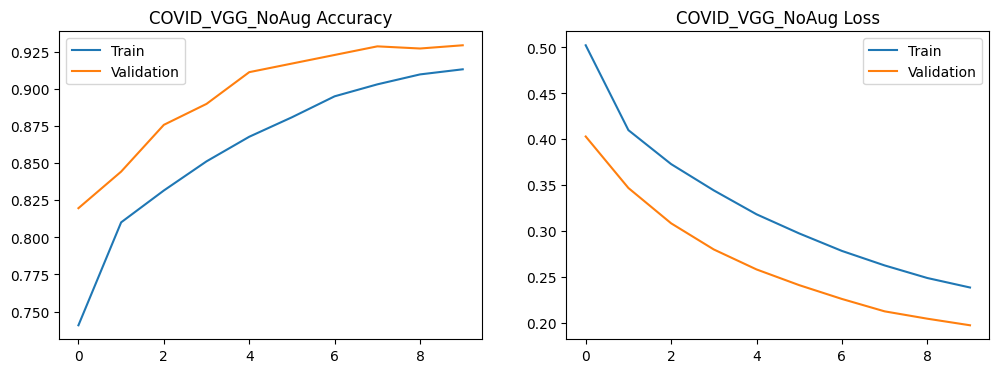

87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step
              precision    recall  f1-score   support

      Normal       0.88      0.85      0.86       723
       COVID       0.95      0.96      0.95      2038

    accuracy                           0.93      2761
   macro avg       0.91      0.90      0.91      2761
weighted avg       0.93      0.93      0.93      2761



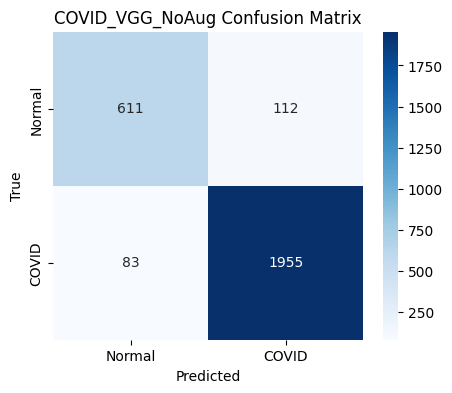

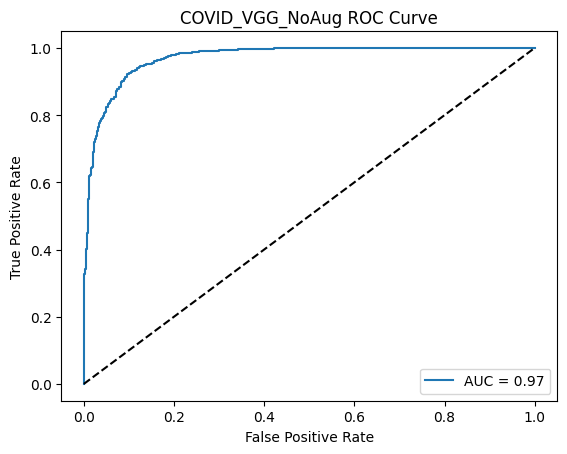

Resultados guardados para: COVID_VGG_NoAug

Dataset: COVID, Modelo: VGG, Augmentation: True
Found 11047 images belonging to 2 classes.
Found 2761 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 163s 466ms/step - accuracy: 0.7537 - loss: 0.5131 - val_accuracy: 0.8044 - val_loss: 0.4054
Epoch 2/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 160s 463ms/step - accuracy: 0.7961 - loss: 0.4314 - val_accuracy: 0.8479 - val_loss: 0.3611
Epoch 3/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 161s 465ms/step - accuracy: 0.8138 - loss: 0.4047 - val_accuracy: 0.8627 - val_loss: 0.3386
Epoch 4/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 160s 464ms/step - accuracy: 0.8239 - loss: 0.3930 - val_accuracy: 0.8736 - val_loss: 0.3208
Epoch 5/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 160s 463ms/step - accuracy: 0.8299 - loss: 0.3777 - val_accuracy: 0.8801 - val_loss: 0.3066
Epoch 6/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 161s 464ms/step - accuracy: 0.8499 - loss: 0.3572 - val_accuracy: 0.8881 - val_loss: 0.2941
Epoch 7/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 161s 467ms/step - accuracy: 0.8597 - loss: 0.3401 - val_accuracy: 0.8942 - val_loss: 0.2907
Epoch 8/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 159s 461ms/step - accuracy: 0.8573 -

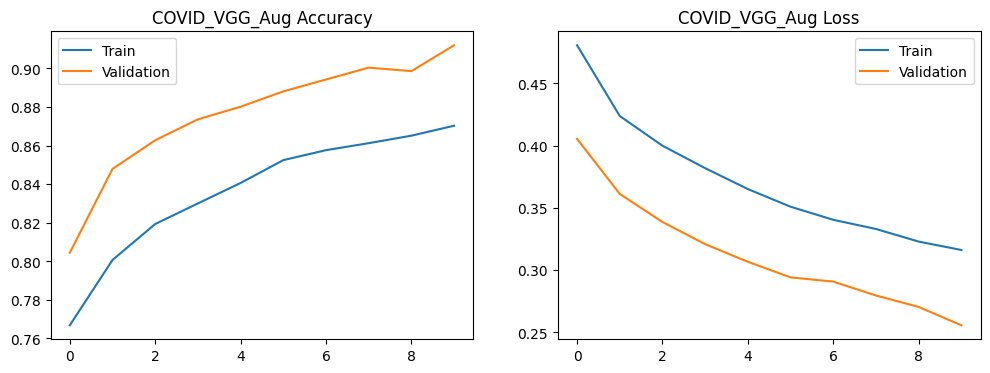

87/87 ━━━━━━━━━━━━━━━━━━━━ 33s 371ms/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step
              precision    recall  f1-score   support

      Normal       0.86      0.75      0.80       723
       COVID       0.92      0.96      0.94      2038

    accuracy                           0.90      2761
   macro avg       0.89      0.85      0.87      2761
weighted avg       0.90      0.90      0.90      2761



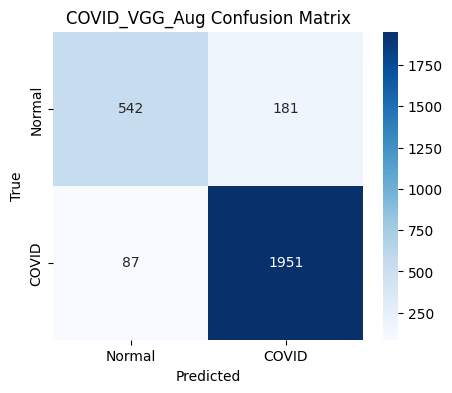

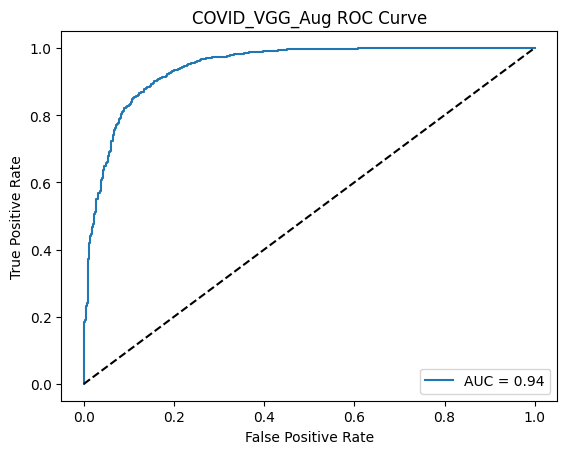

Resultados guardados para: COVID_VGG_Aug

Dataset: COVID, Modelo: RESNET, Augmentation: False
Found 11047 images belonging to 2 classes.
Found 2761 images belonging to 2 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


346/346 ━━━━━━━━━━━━━━━━━━━━ 61s 138ms/step - accuracy: 0.7336 - loss: 0.5786 - val_accuracy: 0.7381 - val_loss: 0.5389
Epoch 2/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 36s 103ms/step - accuracy: 0.7401 - loss: 0.5497 - val_accuracy: 0.7381 - val_loss: 0.5111
Epoch 3/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 36s 103ms/step - accuracy: 0.7348 - loss: 0.5391 - val_accuracy: 0.7381 - val_loss: 0.5051
Epoch 4/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 35s 101ms/step - accuracy: 0.7332 - loss: 0.5258 - val_accuracy: 0.7381 - val_loss: 0.5012
Epoch 5/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 36s 103ms/step - accuracy: 0.7475 - loss: 0.5081 - val_accuracy: 0.7606 - val_loss: 0.4699
Epoch 6/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 35s 102ms/step - accuracy: 0.7446 - loss: 0.5057 - val_accuracy: 0.7385 - val_loss: 0.4646
Epoch 7/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 35s 101ms/step - accuracy: 0.7481 - loss: 0.5000 - val_accuracy: 0.7530 - val_loss: 0.4555
Epoch 8/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 35s 101ms/step - accuracy: 0.7471 - loss: 0.4954 - val

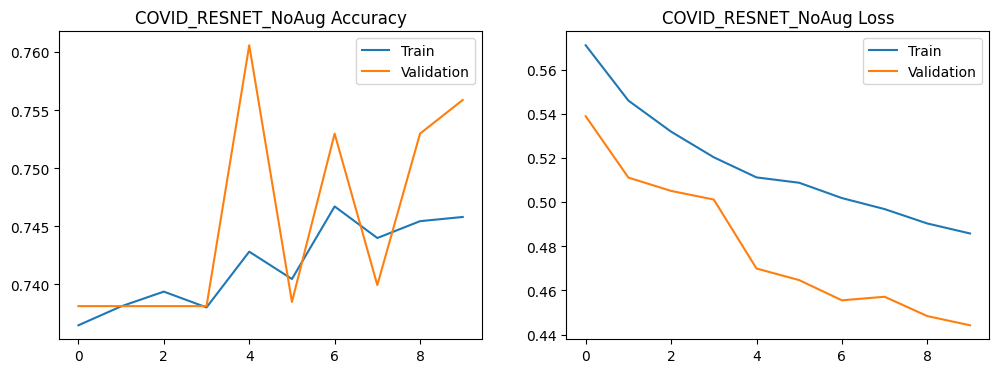

87/87 ━━━━━━━━━━━━━━━━━━━━ 14s 120ms/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step
              precision    recall  f1-score   support

      Normal       0.79      0.09      0.17       723
       COVID       0.75      0.99      0.86      2038

    accuracy                           0.76      2761
   macro avg       0.77      0.54      0.51      2761
weighted avg       0.76      0.76      0.68      2761



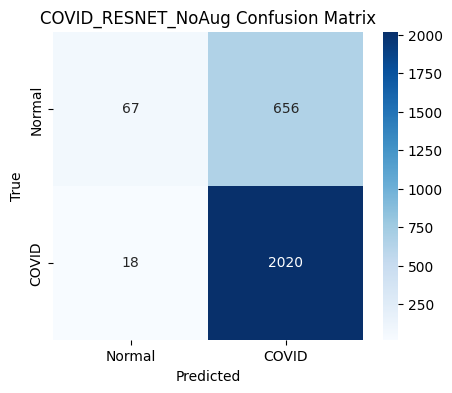

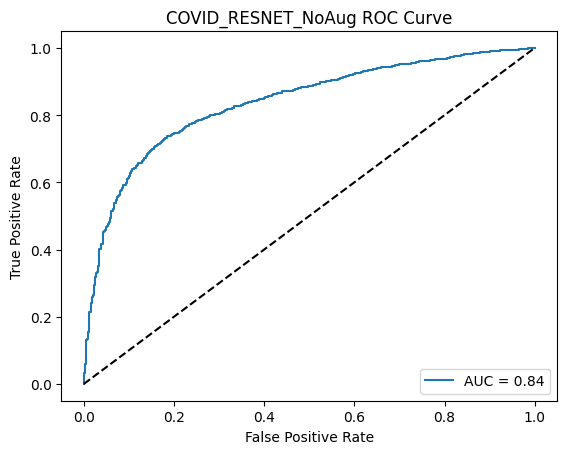

Resultados guardados para: COVID_RESNET_NoAug

Dataset: COVID, Modelo: RESNET, Augmentation: True
Found 11047 images belonging to 2 classes.
Found 2761 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 177s 485ms/step - accuracy: 0.7325 - loss: 0.5761 - val_accuracy: 0.7381 - val_loss: 0.5499
Epoch 2/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 160s 463ms/step - accuracy: 0.7407 - loss: 0.5517 - val_accuracy: 0.7381 - val_loss: 0.5257
Epoch 3/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 162s 467ms/step - accuracy: 0.7375 - loss: 0.5467 - val_accuracy: 0.7381 - val_loss: 0.5115
Epoch 4/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 161s 466ms/step - accuracy: 0.7371 - loss: 0.5364 - val_accuracy: 0.7646 - val_loss: 0.5258
Epoch 5/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 161s 464ms/step - accuracy: 0.7464 - loss: 0.5276 - val_accuracy: 0.7381 - val_loss: 0.5028
Epoch 6/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 161s 466ms/step - accuracy: 0.7349 - loss: 0.5341 - val_accuracy: 0.7381 - val_loss: 0.5166
Epoch 7/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 161s 466ms/step - accuracy: 0.7412 - loss: 0.5287 - val_accuracy: 0.7389 - val_loss: 0.4978
Epoch 8/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 161s 465ms/step - accuracy: 0.7350 -

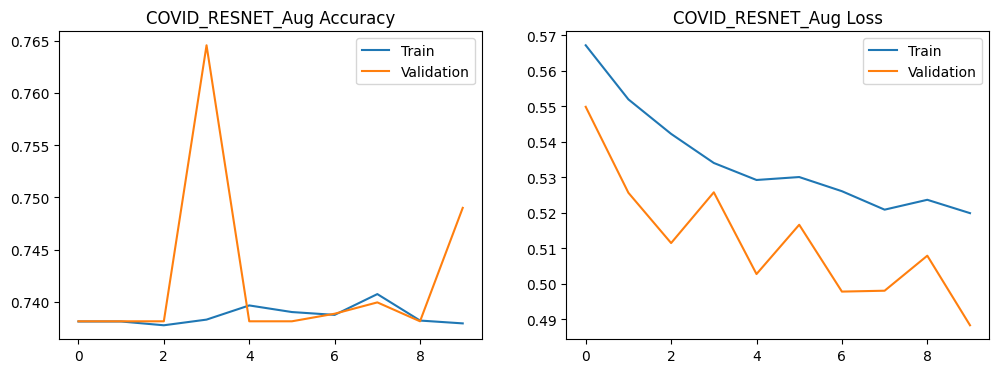

87/87 ━━━━━━━━━━━━━━━━━━━━ 39s 404ms/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step
              precision    recall  f1-score   support

      Normal       0.68      0.08      0.14       723
       COVID       0.75      0.99      0.85      2038

    accuracy                           0.75      2761
   macro avg       0.72      0.53      0.50      2761
weighted avg       0.73      0.75      0.67      2761



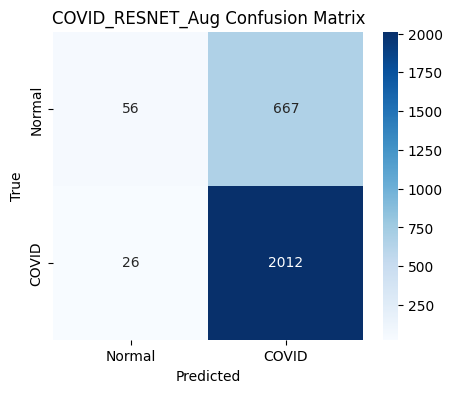

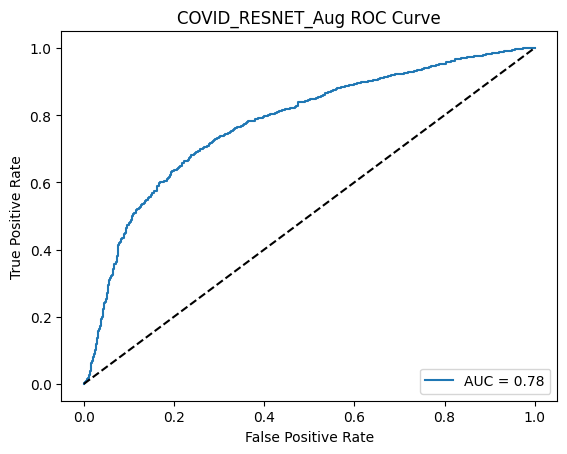

Resultados guardados para: COVID_RESNET_Aug

Dataset: CUB, Modelo: VGG, Augmentation: False
Found 9465 images belonging to 200 classes.
Found 2323 images belonging to 200 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 62s 193ms/step - accuracy: 0.0058 - loss: 5.3388 - val_accuracy: 0.0155 - val_loss: 5.2342
Epoch 2/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 35s 118ms/step - accuracy: 0.0215 - loss: 5.2033 - val_accuracy: 0.0370 - val_loss: 5.1232
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 36s 120ms/step - accuracy: 0.0454 - loss: 5.0773 - val_accuracy: 0.0443 - val_loss: 4.9991
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 34s 116ms/step - accuracy: 0.0557 - loss: 4.9362 - val_accuracy: 0.0611 - val_loss: 4.8816
Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 35s 119ms/step - accuracy: 0.0700 - loss: 4.8203 - val_accuracy: 0.0693 - val_loss: 4.7816
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 34s 115ms/step - accuracy: 0.0761 - loss: 4.7164 - val_accuracy: 0.0680 - val_loss: 4.6963
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 35s 117ms/step - accuracy: 0.0902 - loss: 4.6159 - val_accuracy: 0.0719 - val_loss: 4.6245
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 35s 117ms/step - accuracy: 0.0959 - loss: 4

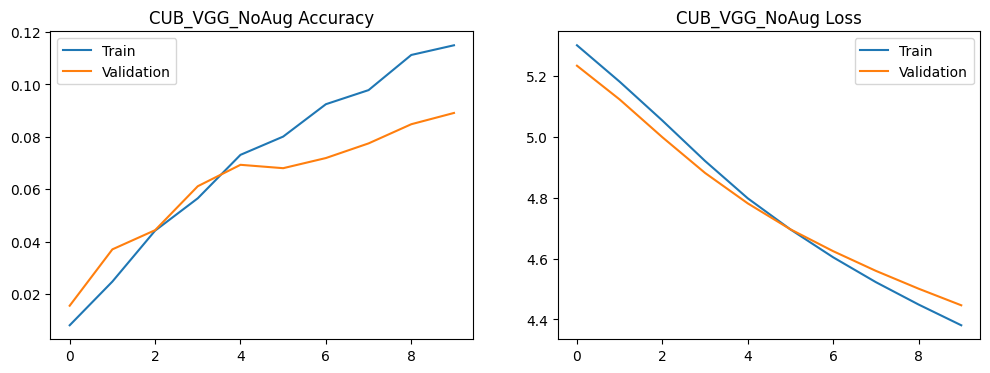

73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step
                                    precision    recall  f1-score   support

        001.Black_footed_Albatross       0.43      0.25      0.32        12
              002.Laysan_Albatross       0.00      0.00      0.00        12
               003.Sooty_Albatross       0.00      0.00      0.00        11
             004.Groove_billed_Ani       0.00      0.00      0.00        12
                005.Crested_Auklet       0.00      0.00      0.00         8
                  006.Least_Auklet       0.33      0.12      0.18         8
               007.Parakeet_Auklet       0.13      0.40      0.20        10
             008.Rhinoceros_Auklet       0.00      0.00      0.00         9
              009.Brewer_Blackbird       0.00      0.00      0.00        11
          010.Red_winged_Blackbird       0.00      0.00      0.00        12
               011.Rusty_Blackbird       0.00      0.00      0.00        12
      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


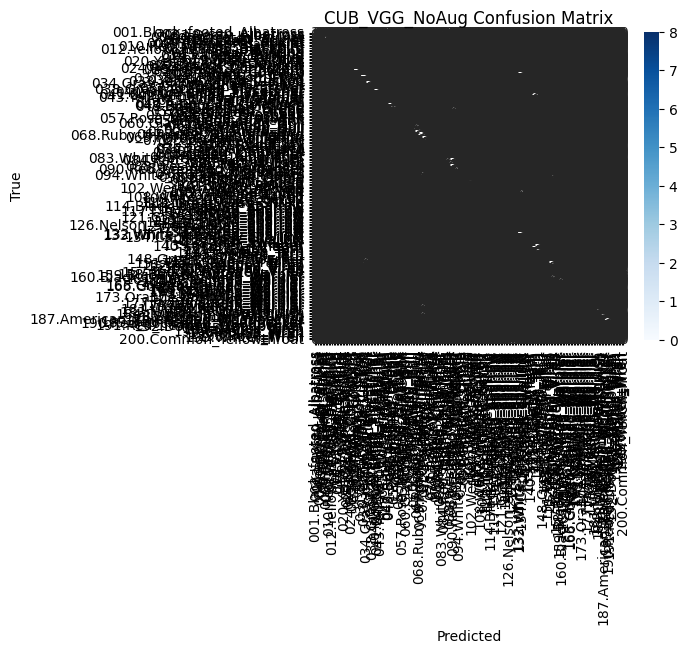

Resultados guardados para: CUB_VGG_NoAug

Dataset: CUB, Modelo: VGG, Augmentation: True
Found 9465 images belonging to 200 classes.
Found 2323 images belonging to 200 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 148s 491ms/step - accuracy: 0.0050 - loss: 5.3405 - val_accuracy: 0.0103 - val_loss: 5.2461
Epoch 2/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 143s 483ms/step - accuracy: 0.0150 - loss: 5.2251 - val_accuracy: 0.0267 - val_loss: 5.1605
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 142s 481ms/step - accuracy: 0.0294 - loss: 5.1286 - val_accuracy: 0.0379 - val_loss: 5.0605
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 142s 479ms/step - accuracy: 0.0418 - loss: 5.0232 - val_accuracy: 0.0478 - val_loss: 4.9597
Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 141s 478ms/step - accuracy: 0.0503 - loss: 4.9068 - val_accuracy: 0.0499 - val_loss: 4.8645
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 143s 482ms/step - accuracy: 0.0612 - loss: 4.7983 - val_accuracy: 0.0590 - val_loss: 4.7803
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 145s 489ms/step - accuracy: 0.0741 - loss: 4.7039 - val_accuracy: 0.0598 - val_loss: 4.7127
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 142s 480ms/step - accuracy: 0.0806 -

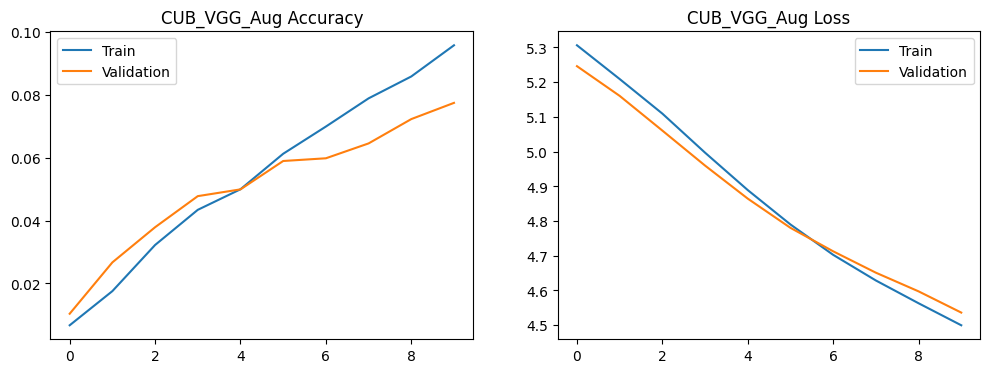

73/73 ━━━━━━━━━━━━━━━━━━━━ 29s 389ms/step
73/73 ━━━━━━━━━━━━━━━━━━━━ 28s 382ms/step
                                    precision    recall  f1-score   support

        001.Black_footed_Albatross       0.33      0.33      0.33        12
              002.Laysan_Albatross       0.00      0.00      0.00        12
               003.Sooty_Albatross       0.00      0.00      0.00        11
             004.Groove_billed_Ani       0.00      0.00      0.00        12
                005.Crested_Auklet       0.00      0.00      0.00         8
                  006.Least_Auklet       1.00      0.12      0.22         8
               007.Parakeet_Auklet       0.38      0.30      0.33        10
             008.Rhinoceros_Auklet       0.00      0.00      0.00         9
              009.Brewer_Blackbird       0.00      0.00      0.00        11
          010.Red_winged_Blackbird       0.00      0.00      0.00        12
               011.Rusty_Blackbird       0.00      0.00      0.00        12
   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


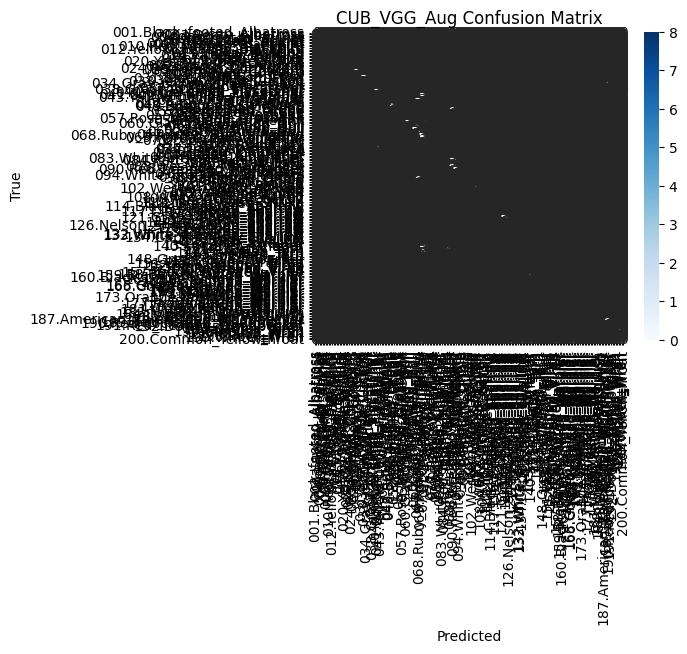

Resultados guardados para: CUB_VGG_Aug

Dataset: CUB, Modelo: RESNET, Augmentation: False
Found 9465 images belonging to 200 classes.
Found 2323 images belonging to 200 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 62s 173ms/step - accuracy: 0.0054 - loss: 5.3862 - val_accuracy: 0.0090 - val_loss: 5.2952
Epoch 2/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 36s 120ms/step - accuracy: 0.0076 - loss: 5.2982 - val_accuracy: 0.0138 - val_loss: 5.2776
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 35s 117ms/step - accuracy: 0.0082 - loss: 5.2787 - val_accuracy: 0.0108 - val_loss: 5.2672
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 35s 119ms/step - accuracy: 0.0100 - loss: 5.2615 - val_accuracy: 0.0090 - val_loss: 5.2531
Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 35s 117ms/step - accuracy: 0.0123 - loss: 5.2385 - val_accuracy: 0.0086 - val_loss: 5.2400
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 35s 119ms/step - accuracy: 0.0149 - loss: 5.2298 - val_accuracy: 0.0116 - val_loss: 5.2272
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 36s 120ms/step - accuracy: 0.0121 - loss: 5.2097 - val_accuracy: 0.0151 - val_loss: 5.2167
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 36s 121ms/step - accuracy: 0.0148 - loss: 5

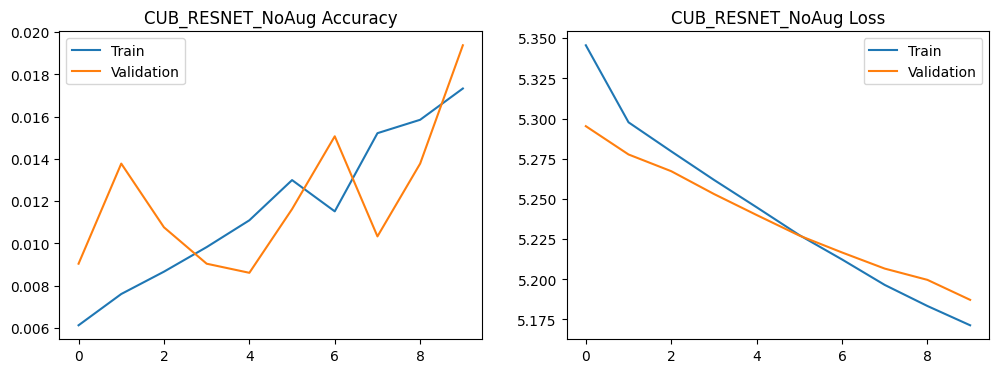

73/73 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step
                                    precision    recall  f1-score   support

        001.Black_footed_Albatross       0.00      0.00      0.00        12
              002.Laysan_Albatross       0.00      0.00      0.00        12
               003.Sooty_Albatross       0.00      0.00      0.00        11
             004.Groove_billed_Ani       0.00      0.00      0.00        12
                005.Crested_Auklet       0.00      0.00      0.00         8
                  006.Least_Auklet       0.00      0.00      0.00         8
               007.Parakeet_Auklet       0.00      0.00      0.00        10
             008.Rhinoceros_Auklet       0.00      0.00      0.00         9
              009.Brewer_Blackbird       0.00      0.00      0.00        11
          010.Red_winged_Blackbird       0.00      0.00      0.00        12
               011.Rusty_Blackbird       0.00      0.00      0.00        12
     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


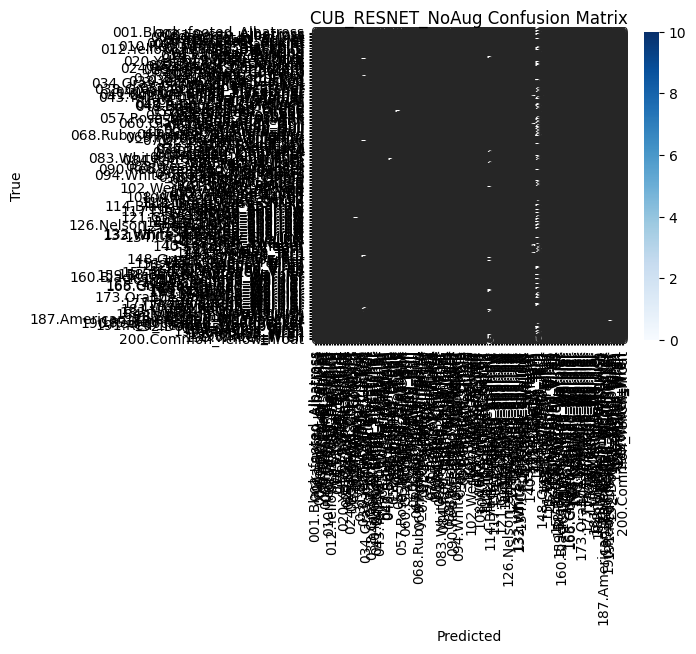

Resultados guardados para: CUB_RESNET_NoAug

Dataset: CUB, Modelo: RESNET, Augmentation: True
Found 9465 images belonging to 200 classes.
Found 2323 images belonging to 200 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 162s 510ms/step - accuracy: 0.0045 - loss: 5.3787 - val_accuracy: 0.0056 - val_loss: 5.2989
Epoch 2/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 142s 479ms/step - accuracy: 0.0054 - loss: 5.3038 - val_accuracy: 0.0065 - val_loss: 5.2850
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 143s 483ms/step - accuracy: 0.0068 - loss: 5.2888 - val_accuracy: 0.0065 - val_loss: 5.2767
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 142s 481ms/step - accuracy: 0.0088 - loss: 5.2762 - val_accuracy: 0.0112 - val_loss: 5.2672
Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 141s 477ms/step - accuracy: 0.0082 - loss: 5.2643 - val_accuracy: 0.0073 - val_loss: 5.2571
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 143s 482ms/step - accuracy: 0.0070 - loss: 5.2507 - val_accuracy: 0.0121 - val_loss: 5.2487
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 141s 478ms/step - accuracy: 0.0113 - loss: 5.2373 - val_accuracy: 0.0116 - val_loss: 5.2388
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 142s 481ms/step - accuracy: 0.0083 -

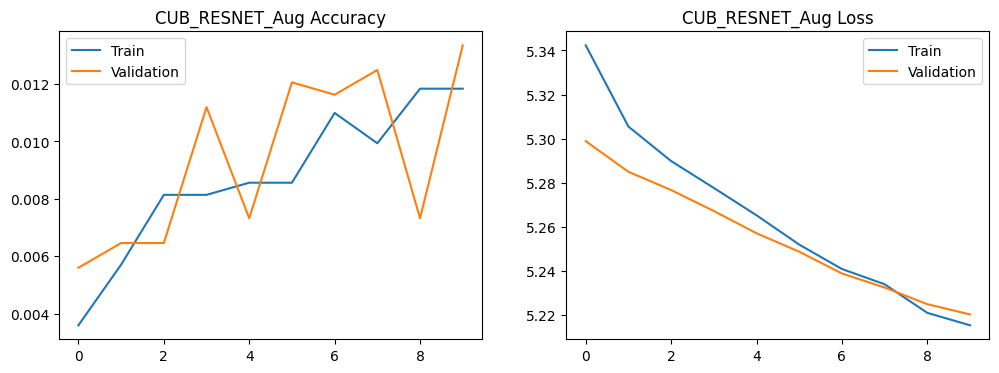

73/73 ━━━━━━━━━━━━━━━━━━━━ 35s 429ms/step
73/73 ━━━━━━━━━━━━━━━━━━━━ 28s 381ms/step
                                    precision    recall  f1-score   support

        001.Black_footed_Albatross       0.00      0.00      0.00        12
              002.Laysan_Albatross       0.00      0.00      0.00        12
               003.Sooty_Albatross       0.00      0.00      0.00        11
             004.Groove_billed_Ani       0.00      0.00      0.00        12
                005.Crested_Auklet       0.00      0.00      0.00         8
                  006.Least_Auklet       0.00      0.00      0.00         8
               007.Parakeet_Auklet       0.00      0.00      0.00        10
             008.Rhinoceros_Auklet       0.00      0.00      0.00         9
              009.Brewer_Blackbird       0.00      0.00      0.00        11
          010.Red_winged_Blackbird       0.00      0.00      0.00        12
               011.Rusty_Blackbird       0.00      0.00      0.00        12
   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


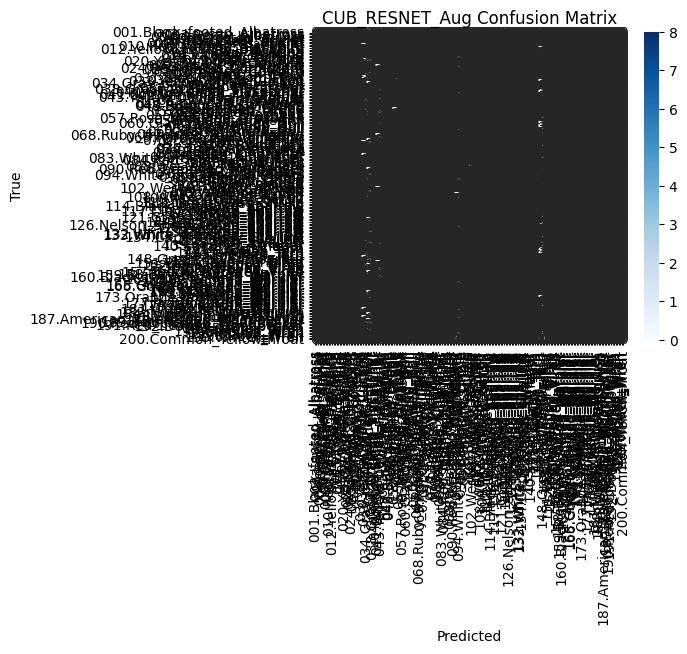

Resultados guardados para: CUB_RESNET_Aug


In [12]:
# ============================
# Definición de experimentos
# ============================
experiments = [
    {
        'dataset': '/content/covid_binary_dataset',  # Ruta del dataset binario (COVID vs NORMAL)
        'class_mode': 'binary',
        'class_names': ['Normal', 'COVID'],
        'num_classes': 1,
        'label': 'COVID'
    },
    {
        'dataset': '/content/cub-200-2011/CUB_200_2011/images',  # Ruta del dataset multiclase
        'class_mode': 'categorical',
        'class_names': None,  # Se extraerán dinámicamente
        'num_classes': 200,
        'label': 'CUB'
    }
]

for exp in experiments:
    for model_name in ['vgg', 'resnet']:
        for aug in [False, True]:
            print("\n==============================")
            print(f"Dataset: {exp['label']}, Modelo: {model_name.upper()}, Augmentation: {aug}")
            print("==============================")

            train_gen, val_gen = prepare_generators(exp['dataset'], augment=aug, class_mode=exp['class_mode'])

            if exp['class_names'] is None:
                class_names = list(train_gen.class_indices.keys())
            else:
                class_names = exp['class_names']

            model = create_model(model_name=model_name, num_classes=exp['num_classes'])

            history = model.fit(train_gen, epochs=10, validation_data=val_gen)

            title = f"{exp['label']}_{model_name.upper()}_{'Aug' if aug else 'NoAug'}"
            plot_metrics(history, title_prefix=title)

            val_gen.reset()
            y_pred = model.predict(val_gen)
            y_true = val_gen.classes

            if y_pred.shape[1] == 1:
                y_pred_labels = (y_pred > 0.5).astype(int)
                y_pred_proba = y_pred
            else:
                y_pred_labels = np.argmax(y_pred, axis=1)
                y_pred_proba = None  # ROC solo para binario

            evaluate_model(model, val_gen, class_names=class_names, title_prefix=title)
            save_results(model, history, title_prefix=title, y_true=y_true, y_pred_labels=y_pred_labels, y_pred_proba=y_pred_proba, class_names=class_names)

# Save results

In [13]:
!cp -r resultados_modelos /content/drive/MyDrive/TFG_resultados/

!zip -r resultados_modelos.zip resultados_modelos

from google.colab import files
files.download("resultados_modelos.zip")

  adding: resultados_modelos/ (stored 0%)
  adding: resultados_modelos/CUB_RESNET_Aug_model.h5 (deflated 11%)
  adding: resultados_modelos/COVID_RESNET_NoAug_model.h5 (deflated 13%)
  adding: resultados_modelos/CUB_VGG_NoAug_confusion_matrix.png (deflated 8%)
  adding: resultados_modelos/CUB_RESNET_Aug_metrics.png (deflated 6%)
  adding: resultados_modelos/COVID_VGG_NoAug_confusion_matrix.png (deflated 11%)
  adding: resultados_modelos/CUB_RESNET_NoAug_metrics.png (deflated 7%)
  adding: resultados_modelos/CUB_VGG_Aug_metrics.png (deflated 6%)
  adding: resultados_modelos/COVID_VGG_Aug_confusion_matrix.png (deflated 10%)
  adding: resultados_modelos/COVID_RESNET_NoAug_history.txt (deflated 54%)
  adding: resultados_modelos/COVID_RESNET_Aug_model.h5 (deflated 12%)
  adding: resultados_modelos/CUB_RESNET_NoAug_confusion_matrix.png (deflated 9%)
  adding: resultados_modelos/COVID_VGG_Aug_history.txt (deflated 50%)
  adding: resultados_modelos/CUB_VGG_NoAug_metrics.png (deflated 6%)
  addi

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>